## TensorFlow教程-keras构建RNN
循环神经网络是一种在时间维度上进行迭代的神经网络，在建模序列数据方面有着优越的性能。
TensorFlow2中包含了主流的rnn网络实现，以Keras RNN API的方式提供调用。其特性如下：
- 易用性： 内置tf.keras.layers.RNN，tf.keras.layers.LSTM，tf.keras.layers.GRU， 可以快速构建RNN模块。
- 易于定制：可以使用自定义操作循环来构建RNN模块，并通过tf.keras.layers.RNN调用。


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import collections
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers

2.8.0


### 1 构建一个简单模型
keras中内置了三个RNN层
- tf.keras.layers.SimpleRNN，普通RNN网络。
- tf.keras.layers.GRU，门控循环神经网络。
- tf.keras.layers.LSTM，长短期记忆神经网络。
下面是一个循环神经网络的例子，它使用LSTM层来处理输入的词嵌入，LSTM迭代的次数与词个个数一致


In [4]:
model = tf.keras.Sequential()
# input_dim是词典大小， output_dim是词嵌入维度
model.add(layers.Embedding(input_dim=1000, output_dim=64))
# 添加lstm层，其会输出最后一个时间步输出
model.add(layers.LSTM(128))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


### 2 输出和状态
默认情况下RNN层输出最后一个时间步的输出，输出的形状为(batch_size, units), 其中unit是传给层的构造参数。
如果要返回rnn每个时间步的序列，需要置return_sequence=True, 此时输出的形状为(batch_size, time_steps, units)。

In [6]:
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))
# 反馈整个RNN序列输出
model.add(layers.GRU(128, return_sequences=True))
model.add(layers.SimpleRNN(128))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, None, 128)         74496     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 172,682
Trainable params: 172,682
Non-trainable params: 0
_________________________________________________________________


RNN层可以返回最后一个时间步的状态。

返回的状态可以用于恢复RNN或初始化另一个RNN。此设置通常在seq2seq模型中用到，其将编码器的最终状态作为解码器的初始状态。

要使RNN层返回最终的状态需要在创建图层时置return_state=True。请注意，LSTM有两个状态向量，而GRU只有一个。

要配置图层的初始状态， 需要网络构建中传入initial_state。其中状态的维度必须与图层的unit大小一样。

In [8]:
encoder_vocab = 1000
decoder_vocab = 2000

# 编码层
encode_input = layers.Input(shape=(None, ))
encode_emb = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(encode_input)
# 同时返回状态
encode_out, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(encode_emb)
encode_state = [state_h, state_c]

# 解码层
decode_input = layers.Input(shape=(None, ))
decode_emb = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(decode_input)
# 编码器的最终状态, 作为解码器的初始状态
decode_out = layers.LSTM(64, name='decoder')(decode_emb, initial_state=encode_state)
output = layers.Dense(10, activation='softmax')(decode_out)
model = tf.keras.Model([encode_input, decode_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, None, 64)     64000       ['input_2[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, None, 64)     64000       ['input_3[0][0]']                
                                                                                              

### 3 RNN层和RNN Cell
除了内置的RNN层以外， RNN API还提供单元级API。与可以处理整批次的输入序列不同， RNN Cell仅能处理单个时间步的数据。
如果想处理整批次的输入数据，需要将RNN Cell包含在tf.keras.layers.RNN中， 如：RNN(LSTMCell(10)

同效果上说， RNN(LSTMCell(10))等价于LSTM(10)。但内置的GRU和LSTM层可以使用CuDNN，以提高计算性能。

下面是三个内置的RNN单元， 以及其对应的RNN层。
- tf.keras.layers.SimpleRNNCell对应于SimpleRNN图层。
- tf.keras.layers.GRUCell对应于GRU图层。
- tf.keras.layers.LSTMCell对应于LSTM图层。

注： tf.keras.layers.RNN类可以使为研究实现自定义RNN体系结构变得非常容易。

In [9]:
model = tf.keras.Sequential()
# input_dim是词典大小， output_dim是词嵌入维度
model.add(layers.Embedding(input_dim=1000, output_dim=64))
# 添加lstm层，其会输出最后一个时间步的输出
model.add(layers.RNN(layers.LSTMCell(64)))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 64)          64000     
                                                                 
 rnn (RNN)                   (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 97,674
Trainable params: 97,674
Non-trainable params: 0
_________________________________________________________________


## 4 跨批次状态
在处理超长序列（有可能无限长）时，可能需要使用到跨批次状态的模式。

通常，每次看到新的批次时， 都会重置RNN层的内部状态（state，非权重。即该层看到的每个样本都独立于过去）。

但，当序列过长，需要分不同批次输入时，则无需重置RNN的状态(上一批的结束状态，为下一批的初始状态)。这样，即使一次只看到一个子序列，网络层也可以保留整个序列的信息。

我们可以置state_ful=True来设置跨批次状态。

如果有序列s = [t0, t1, ... t1546, t1547]， 可以将其分为以下批次数据：


s1 = [t0, t1, ... t100]

s2 = [t101, ... t201]

...

16 = [t1501, ... t1547]

具体调用方法如下：

In [10]:
sub_sequence = []
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequence:
    output = lstm_layer(s)

要清除状态时，可以使用layer.reset_states()。

注意：在此设置中，i假定给定批次中的样品i是上一个批次中样品的延续。这意味着所有批次应包含相同数量的样本（批次大小）。例如，如果一个批次包含[sequence_A_from_t0_to_t100, sequence_B_from_t0_to_t100]，则下一个批次应包含[sequence_A_from_t101_to_t200,sequence_B_from_t101_to_t200]。


In [11]:
para1 = np.random.random((20, 10, 50)).astype(np.float32)
para2 = np.random.random((20, 10, 50)).astype(np.float32)
para3 = np.random.random((20, 10, 50)).astype(np.float32)
lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(para1)
output = lstm_layer(para2)
output = lstm_layer(para3)
lstm_layer.reset_states()


### 5 双向LSTM
对于时间序列以外的序列，比如文本，RNN不仅可以正向处理序列，也可以反向处理序列。例如要预测句子的某个单纯，上下文对单词都有用。

Keras提供了tf.keras.layers.Bidirectional的API，构建双向RNN。


In [12]:
model = tf.keras.Sequential()
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True),
                                input_shape=(5, 10)))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 128)           38400     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


在内部， Bidirectional将复制传入的RNN，并将逆序输入新复制的RNN，并输出前向输出和后向输出的叠加。如果想要其他合并行为（如串联），可以修改merge_mode等参数。

### 6 TensorFlow2.0中的性能优化和CuDNN内核

在TensorFlow2.0中，内置的LSTM和GRU层已更新，已在有GPU时默认使用CuDNN内核。通过此更改，先前的keras.layers.CuDNNLSTM/CuDNNGRU层已经弃用，可以简易的构建模型而不必担心其运行的硬件。

由于CuDNN内核是根据某些假设构建的，因此如果改变内置LSTM或GRU的默认设置，则该层无法使用CuDNN内核，例如:

- 将activation从tanh改为其他激活函数。
- 将recurrent_activation由sigmoid改为其他激活函数。
- 使recurrent_dropout> 0。
- 设置unroll为True，将强制LSTM / GRU将内部分解tf.while_loop为展开的for循环。
- 设置use_bias为False。
- 当输入数据未严格右填充时使用掩蔽（如果掩码对应于严格右填充数据，则仍可以使用CuDNN。这是最常见的情况）。

### 6.1 在可用时使用CuDNN内核
我们构建一个简单的LSTM网络，来实现MNIST数字识别。

In [13]:
batch_size = 64
input_dim = 28
units = 64
output_size = 10

def build_model(allow_cudnn_kernel=True):
    if allow_cudnn_kernel:
        # LSTM默认cudnn加速
        lstm_layer = tf.keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # LSTMCell内核没有使用
        lstm_layer = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(units),
                                        input_shape=(None, input_dim))
    model = tf.keras.models.Sequential([
        lstm_layer,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(output_size, activation='softmax')
    ])
    return model

In [14]:
# 加载mnist数据集
mnits = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnits.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]


In [15]:
# 创建模型实例并进行编译
model = build_model(allow_cudnn_kernel=True)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='sgd',
             metrics=['accuracy'])

In [16]:
# 使用cudnn的训练
model.fit(x_train, y_train,
         validation_data=(x_test, y_test),
         batch_size=batch_size,
         epochs=2)

Epoch 1/2
938/938 [==============================] - 15s 14ms/step - loss: 0.9832 - accuracy: 0.6872 - val_loss: 0.5579 - val_accuracy: 0.8258
Epoch 2/2
938/938 [==============================] - 17s 18ms/step - loss: 0.4176 - accuracy: 0.8728 - val_loss: 0.3157 - val_accuracy: 0.8976


In [17]:
# 在没有CuDNN内核的情况下构建新模型
slow_model = build_model(allow_cudnn_kernel=False)
#slow_model.set_weights(model.get_weights())
slow_model.compile(loss='sparse_categorical_crossentropy',
             optimizer='sgd',
             metrics=['accuracy'])
slow_model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=batch_size,
              epochs=2)

Epoch 1/2
938/938 [==============================] - 19s 19ms/step - loss: 0.9258 - accuracy: 0.7050 - val_loss: 0.5164 - val_accuracy: 0.8342
Epoch 2/2
938/938 [==============================] - 17s 18ms/step - loss: 0.3774 - accuracy: 0.8855 - val_loss: 0.4159 - val_accuracy: 0.8632


预测结果: [3], 正确标签: 5


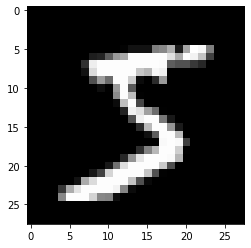

In [18]:
with tf.device('CPU:0'):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print('预测结果: %s, 正确标签: %s' % (result.numpy(), sample_label))
    plt.imshow(sample, cmap=plt.get_cmap('gray'))

### 7.具有列表/字典输入或嵌套输入的RNN
嵌套结构可以在单个时间步内包含更多信息。例如，一个视频帧可以同时具有音频和视频输入。比如以下的数据格式：

[batch, timestep, {"video": [height, width, channel], "audio": [frequency]}]

另一个例子，如笔迹数据。可以有当前的位置坐标x，y和压力信息。格式如下：

[batch, timestep, {"location": [x, y], "pressure": [force]}]

#### 7.1 定义一个支持嵌套输入/输出的自定义单元格

In [20]:
NestedInput = collections.namedtuple('NestedInput', ['feature1', 'feature2'])
NestedState = collections.namedtuple('NestedState', ['state1', 'state2'])

class NestedCell(tf.keras.layers.Layer):
    # 初始化，获取相关参数
    def __init__(self,unit1, unit2, unit3, **kwargs):
        self.unit1 = unit1
        self.unit2 = unit2
        self.unit3 = unit3
        self.state_size = NestedState(state1=unit1,
                                     state2=tf.TensorShape([unit2, unit3]))
        self.output_size = (unit1, tf.TensorShape([unit2, unit3]))
        super(NestedCell, self).__init__(**kwargs)
    
    # 构建权重、网络
    def build(self, input_shapes):
        # input_shape包含2个特征项 [(batch, i1), (batch, i2, i3)]
        input1 = input_shapes.feature1[1]
        input2, input3 = input_shapes.feature2[1:]
        self.kernel_1 = self.add_weight(
            shape=(input1, self.unit1), initializer='uniform', name='kernel_1'
        )
        self.kernel_2_3 = self.add_weight(
            shape=(input2, input3, self.unit2, self.unit3),
            initializer='uniform',
            name='kernel_2_3'
        )
    
    # 前向连接网络
    def call(self, inputs, states):
        # inputs: [(batch, input_1), (batch, input_2, input_3)]
        # state: [(batch, unit_1), (batch, unit_2, unit_3)]
        input1, input2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input1, self.kernel_1)
        output_2_3 = tf.einsum('bij,ijkl->bkl', input2, self.kernel_2_3)
        
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = [output_1, output_2_3]
        new_states = NestedState(state1=state_1, state2=state_2_3)
        return output, new_states

### 7.2 使用嵌套的输入输出构建RNN

In [21]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

input_1 = 32
input_2 = 64
input_3 = 32
batch_size = 64
num_batch = 100
timestep = 50
cell = NestedCell(unit_1, unit_2, unit_3)
rnn = tf.keras.layers.RNN(cell)
input1 = tf.keras.Input((None, input_1))
input2 = tf.keras.Input((None, input_2, input_3))
outputs = rnn(NestedInput(feature1=input1, feature2=input2))
model = tf.keras.models.Model([input1, input2], outputs)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, 32)]   0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, None, 64, 3  0           []                               
                                2)]                                                               
                                                                                                  
 rnn_2 (RNN)                    [(None, 10),         1229120     ['input_4[0][0]',                
                                 (None, 20, 30)]                  'input_5[0][0]']                
                                                                                            

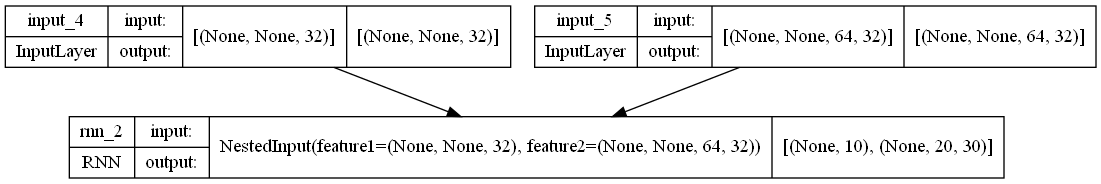

In [24]:
tf.keras.utils.plot_model(model, to_file='./picture/defined_rnn.png', show_shapes=True)